In [1]:
import numpy as np
from jesse import helpers, research

_, trading_1m = research.get_candles(
    "Binance Spot",
    "BTC-USDT",
    "1m",
    helpers.date_to_timestamp("2020-01-01"),
    helpers.date_to_timestamp("2025-01-01"),
    warmup_candles_num=0,
    caching=False,
    is_for_jesse=False,
)

print(trading_1m.shape)

np.save("data/btc_1m.npy", trading_1m)

(2630880, 6)


In [2]:
import numpy as np

candles = np.load("data/btc_1m.npy")
print(candles.shape)
candles[0, 0]


(2630880, 6)


1577836800000.0

In [3]:
import pandas as pd
from jesse.utils import numpy_candles_to_dataframe

df = numpy_candles_to_dataframe(candles)
df["hlret"] = np.log(df["high"] / df["low"])
ret_list = []
for i in range(1, 150):
    ret_series = np.log(df["close"] / df["close"].shift(i))
    ret_series.name = f"ret{i}"
    ret_list.append(ret_series)
df = pd.concat([df, pd.concat(ret_list, axis=1)], axis=1)
del ret_list
df = df[df["ret149"].notna()]

del candles
df.head()


,date,open,close,high,low,volume,hlret,ret1,ret2,ret3,...,ret140,ret141,ret142,ret143,ret144,ret145,ret146,ret147,ret148,ret149
2020-01-01 02:29:00,2020-01-01 02:29:00,7233.19,7228.09,7233.57,7225.76,7.972429,0.001080,-0.000774,-0.000790,-0.000098,...,0.005135,0.005606,0.006166,0.006397,0.006677,0.006706,0.005848,0.006337,0.006114,0.005746
2020-01-01 02:30:00,2020-01-01 02:30:00,7227.12,7232.89,7233.14,7226.79,4.631254,0.000878,0.000664,-0.000111,-0.000126,...,0.006315,0.005799,0.006270,0.006830,0.007061,0.007341,0.007370,0.006512,0.007001,0.006778
2020-01-01 02:31:00,2020-01-01 02:31:00,7232.35,7231.50,7233.84,7229.47,13.106277,0.000604,-0.000192,0.000472,-0.000303,...,0.005935,0.006123,0.005607,0.006078,0.006637,0.006869,0.007148,0.007178,0.006320,0.006809
2020-01-01 02:32:00,2020-01-01 02:32:00,7231.69,7232.77,7233.14,7229.78,18.132154,0.000465,0.000176,-0.000017,0.000647,...,0.006345,0.006110,0.006298,0.005782,0.006254,0.006813,0.007044,0.007324,0.007353,0.006496
2020-01-01 02:33:00,2020-01-01 02:33:00,7232.06,7231.68,7236.07,7230.19,10.299170,0.000813,-0.000151,0.000025,-0.000167,...,0.006882,0.006195,0.005960,0.006147,0.005631,0.006103,0.006662,0.006893,0.007173,0.007203


In [4]:
np.load("data/btc_1m.npy")[149:].shape[0] == len(df)

True

所有交点： [-0.027702444058028273, -0.005059659727813367, 0.005449535236276429, 0.028023737384271656]


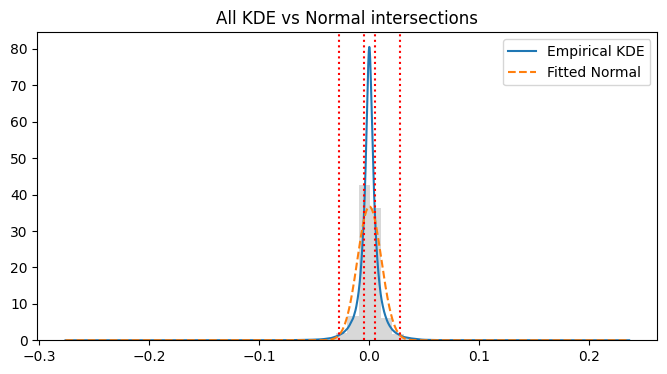

In [5]:
from custom_indicators.utils.plot import find_kde_cross

target = df["ret149"].to_numpy()
roots = find_kde_cross(target)


In [6]:
series = df["ret149"].copy().sort_values()
label = ((series <= roots[0]) | (series >= roots[-1])).astype(int)
label.sort_index(inplace=True)
label.value_counts()

ret149
0    2555727
1      75004
Name: count, dtype: int64

In [17]:
import warnings

from gplearn.fitness import make_fitness
from gplearn.genetic import SymbolicRegressor
from scipy import stats

from custom_indicators.toolbox.bar.build import (
    build_bar_by_threshold_greater_than,
    build_bar_by_threshold_less_than,
)


def gp_kurtosis(y, y_pred, w):
    warnings.filterwarnings("ignore", category=RuntimeWarning)

    if len(y_pred) <= 2:
        return 1000

    candles_in_metrics = np.load("data/btc_1m.npy")[149:]

    assert len(candles_in_metrics) == len(y_pred), (
        f"{len(candles_in_metrics)} != {len(y_pred)}"
    )
    # sigmoid y_pred
    sigmoid_y_pred = 1 / (1 + np.exp(-y_pred))
    if all(sigmoid_y_pred > 0.5) or all(sigmoid_y_pred < 0.5):
        return 1000

    merged_bar_1 = build_bar_by_threshold_greater_than(
        candles_in_metrics,
        sigmoid_y_pred,
        0.5,
        reverse=False,
    )
    if len(merged_bar_1) < 2000:
        return 1000

    log_ret_1 = np.log(merged_bar_1[1:, 2] / merged_bar_1[:-1, 2])
    std_log_ret_1 = (log_ret_1 - log_ret_1.mean()) / log_ret_1.std()

    merged_bar_2 = build_bar_by_threshold_less_than(
        candles_in_metrics,
        sigmoid_y_pred,
        0.5,
        reverse=True,
    )
    if len(merged_bar_2) < 2000:
        return 1000

    log_ret_2 = np.log(merged_bar_2[1:, 2] / merged_bar_2[:-1, 2])
    std_log_ret_2 = (log_ret_2 - log_ret_2.mean()) / log_ret_2.std()

    kurtosis_1 = stats.kurtosis(std_log_ret_1)
    kurtosis_2 = stats.kurtosis(std_log_ret_2)
    return min(kurtosis_1, kurtosis_2)


custom_kurtosis_loss = make_fitness(
    function=gp_kurtosis,
    greater_is_better=False,
    wrap=True,
)

cols = [f"ret{i}" for i in range(1, 150)] + ["hlret", "volume"]

est_gp = SymbolicRegressor(
    metric=custom_kurtosis_loss,
    population_size=5000,
    generations=20,
    tournament_size=50,
    stopping_criteria=0,
    function_set=["add", "sub", "sqrt", "log", "abs", "neg", "max", "min"],
    p_crossover=0.7,
    p_subtree_mutation=0.05,
    p_hoist_mutation=0.1,
    p_point_mutation=0.1,
    max_samples=1,
    parsimony_coefficient=0.006,
    feature_names=cols,
    verbose=1,
    n_jobs=10,
    random_state=0,
)

est_gp.fit(df[cols], label)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0     9.00          713.702       52          12.6812              N/A     42.36m
   1    18.70          321.376       44           10.111              N/A     47.23m
   2    23.72           326.17       29          8.59521              N/A     46.97m
   3    34.31          283.234       40          8.38612              N/A     48.86m
   4    34.56          258.427       73          8.11941              N/A     58.84m
   5    29.41            202.5       37          7.17977              N/A     52.94m
   6    30.47          198.277       41          6.23176              N/A     48.38m
   7    30.77          208.998       42          6.19329              N/A     44.24m
   8    38.15          150.392       42          6.01176              N/A  

SymbolicRegressor(feature_names=['ret1', 'ret2', 'ret3', 'ret4', 'ret5', 'ret6',
                                 'ret7', 'ret8', 'ret9', 'ret10', 'ret11',
                                 'ret12', 'ret13', 'ret14', 'ret15', 'ret16',
                                 'ret17', 'ret18', 'ret19', 'ret20', 'ret21',
                                 'ret22', 'ret23', 'ret24', 'ret25', 'ret26',
                                 'ret27', 'ret28', 'ret29', 'ret30', ...],
                  function_set=['add', 'sub', 'sqrt', 'log', 'abs', 'neg',
                                'max', 'min'],
                  max_samples=1,
                  metric=<gplearn.fitness._Fitness object at 0x3601c8910>,
                  n_jobs=10, p_crossover=0.7, p_hoist_mutation=0.1,
                  p_point_mutation=0.1, p_subtree_mutation=0.05,
                  parsimony_coefficient=0.006, population_size=5000,
                  random_state=0, stopping_criteria=0, tournament_size=50,
                  verbose=1)

In [31]:
import pandas as pd

fitness_list = []
program_list = []

for lst in est_gp._programs:
    for program in lst:
        if program and program.fitness_ < 9:
            fitness_list.append(program.fitness_)
            program_list.append(str(program))

df_res = pd.DataFrame(
    {"fitness": fitness_list, "program": program_list}
).drop_duplicates(subset=["program"])
df_res.sort_values(by="fitness", inplace=True)
df_res.head(10)


,fitness,program
1970,5.035189,"log(log(min(add(abs(log(ret45)), log(sqrt(ret4..."
928,5.035397,"log(log(min(add(abs(log(ret45)), log(sqrt(ret4..."
2100,5.053475,"log(log(min(add(abs(log(ret45)), log(sqrt(ret4..."
736,5.117382,"log(log(min(add(abs(log(ret45)), log(sqrt(ret4..."
519,5.185769,"log(log(min(add(abs(log(ret45)), log(sqrt(ret4..."
2153,5.191769,"log(log(min(add(abs(log(ret45)), log(sqrt(ret4..."
1157,5.199644,"log(log(min(add(abs(log(ret45)), log(sqrt(ret4..."
1564,5.233769,"log(log(min(add(abs(log(ret45)), log(sqrt(ret4..."
1329,5.241194,"log(log(min(add(abs(log(ret45)), log(sqrt(ret4..."
871,5.259501,"log(log(min(add(abs(log(ret45)), log(sqrt(ret4..."


In [32]:
for fitness, program in zip(df_res["fitness"], df_res["program"]):
    print(f"{fitness = }: {program}")


fitness = 5.035189445436784: log(log(min(add(abs(log(ret45)), log(sqrt(ret45))), min(add(ret48, min(neg(add(neg(min(add(abs(log(ret44)), log(sqrt(ret45))), neg(hlret))), sqrt(ret36))), sqrt(ret45))), add(abs(log(ret44)), log(add(sub(ret36, ret7), sqrt(ret39))))))))
fitness = 5.0353967968231235: log(log(min(add(abs(log(ret45)), log(sqrt(ret45))), min(add(ret48, min(neg(add(neg(min(add(abs(log(ret44)), log(sqrt(ret45))), neg(hlret))), sqrt(ret36))), ret104)), add(abs(log(ret44)), log(add(sub(ret36, ret7), sqrt(ret39))))))))
fitness = 5.053475473392728: log(log(min(add(abs(log(ret45)), log(sqrt(ret45))), min(add(ret48, min(neg(add(neg(min(add(abs(log(ret44)), add(abs(log(ret44)), log(sqrt(ret45)))), neg(hlret))), sqrt(ret36))), ret104)), add(abs(log(ret44)), log(add(sub(ret36, ret7), sqrt(ret39))))))))
fitness = 5.117382112025092: log(log(min(add(abs(log(ret45)), log(sqrt(ret45))), min(add(ret53, neg(add(neg(min(add(abs(log(ret44)), log(sqrt(ret45))), neg(hlret))), sqrt(ret36)))), add(abs